# Instagram Insights 


In [11]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

with open("/home/riccardo/tools/instagram-scraper/instagram_scraper/ducatimotor/ducatimotor.json") as f:
    j = json.load(f)

In [12]:
def clean_json(j):
    '''
    Extract from the metadata only the relevant information
    '''
    try:
        new_json = {}
        new_json['caption'] = j['caption']['text']
        new_json['time'] = j['caption']['created_time']
        new_json['n_comment'] = j['comments']['count']
        new_json['n_likes'] = j['likes']['count']
        new_json['type'] = j['type']
        return new_json
    except:
        return None
    
cleared_data = [clean_json(e) for e in j] # run the transform on every media
cleared_data = [clear for clear in cleared_data if clear]

In [13]:
data_frame = pd.DataFrame.from_dict(cleared_data)
data_frame.head()

,caption,n_comment,n_likes,time,type
0,"""I needed a motorbike smart and agile for my e...",0,561,1495805062,image
1,The genuine leather seat is an exclusive and u...,1,1942,1495790766,image
2,Imagine riding to the racetrack with the full ...,17,8423,1495732554,image
3,#Repost @willdavison__ /\nHave absolutely love...,9,4533,1495726613,image
4,"At the beginning of the 70's, Ducati began the...",6,3376,1495719137,image


In [14]:
def fix_time(time, format):
    return(
    datetime.datetime.fromtimestamp(
        int(time)
    ).strftime(format) # Convert the time into year month day hour format
)

In [15]:
'''
Convert the timestamp into a fine time data, but I want also to split the part of the time data into year, month, day and hour
'''
times = data_frame['time']

time_formats = ["%Y", "%m", "%w", "%H"]
for format_type in time_formats:
    data_frame = pd.concat([data_frame,(times.apply(fix_time, format=(format_type))).rename(format_type)], axis=1)

data_frame = data_frame.drop("time", axis=1)

#data_frame['%d'] = data_frame['%d'].apply(fix_day)
data_frame.head()

,caption,n_comment,n_likes,type,%Y,%m,%w,%H
0,"""I needed a motorbike smart and agile for my e...",0,561,image,2017,05,5,15
1,The genuine leather seat is an exclusive and u...,1,1942,image,2017,05,5,11
2,Imagine riding to the racetrack with the full ...,17,8423,image,2017,05,4,19
3,#Repost @willdavison__ /\nHave absolutely love...,9,4533,image,2017,05,4,17
4,"At the beginning of the 70's, Ducati began the...",6,3376,image,2017,05,4,15


## Grouping by the weekday
Now that the data is cleaned, we can start extracting some useful insights.
We begin with looking at what weekday a post receives more likes.

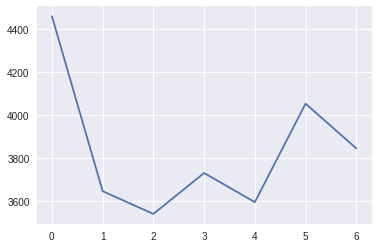

In [16]:
%matplotlib inline
plt.plot(data_frame.groupby(["%w"]).median()['n_likes'])

## Grouping by the hour
We can now move on and discover what is the best hour for posting.

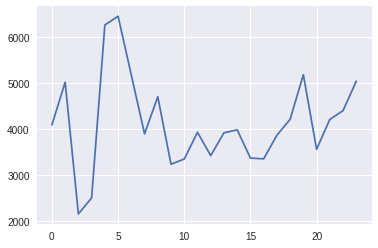

In [17]:
%matplotlib inline
plt.plot(data_frame.groupby(["%H"]).median()['n_likes'])

## Number of likes heatmap
The question is: what's the optimal time for posting according to my audience? <br>
We want to mix the previous information and find some more useful data.<br>
Heatmaps really come handy in this kind of situations.

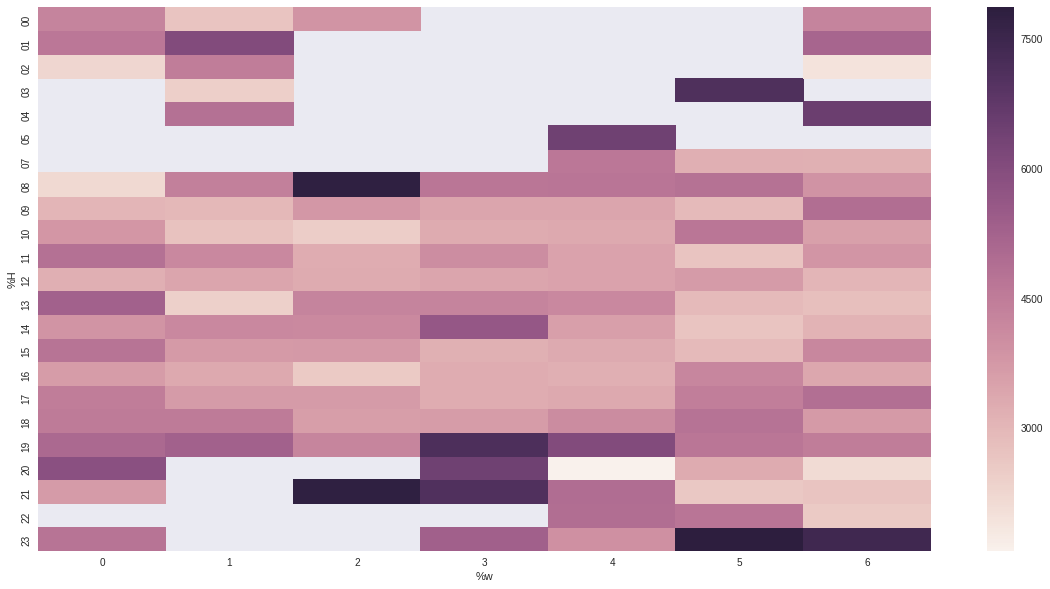

In [18]:
# total borrowed from https://stackoverflow.com/questions/34225839/groupby-multiple-values-and-plotting-results

apple_fplot = data_frame.groupby(["%w","%H"]).median()
plot_df = apple_fplot.unstack('%w').loc[:, 'n_likes']
fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches

sns.heatmap(plot_df,ax=ax)

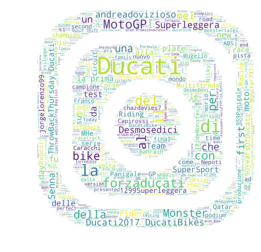

In [19]:
'''
The positive outliers aka the posts that received a bigger number of likes compared to the others 
'''
positive_outliers = data_frame[data_frame['n_likes'] > data_frame['n_likes'].quantile(0.95)]

'''
The negative outliers aka the posts that received the fewest number of likes 
'''
negative_outliers = data_frame[data_frame['n_likes'] < data_frame['n_likes'].quantile(0.05)]

def make_wordcloud(corpus):
    from os import path
    from PIL import Image
    import numpy as np
    import matplotlib.pyplot as plt

    from wordcloud import WordCloud, STOPWORDS
    insta_mask = np.array(Image.open("instagram_mask.png"))
    stopwords = set(STOPWORDS)

    wc = WordCloud(background_color="white", max_words=2000, mask=insta_mask,
                    stopwords=stopwords)
    # generate word cloud
    wc.generate(corpus)
   
    plt.figure()
    plt.axis("off")
    plt.imshow(insta_mask, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
    plt.imshow(wc, interpolation='bilinear')
    wc.to_file("instagram.png")
    plt.show()

make_wordcloud(" ".join(positive_outliers['caption']))

# Machine Learning
Now on the serious things, the aim of this section is to create a model that can predict, given a post, the number of likes that that post will get.<br>
I used a **SVR** or **S**upport **V**ector **R**egression for this task.<br>
The only dependency is Sklearn and matplotlib.

> **NOTE**: This is a work in progress section, no accurate result expected

The hyperparameters tuning is made totally **by hand**, what a *rude* man am I?

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

def get_hashtags(caption):
    return " ".join([hashtag for hashtag in caption.split() if hashtag.startswith('#')])

#data_frame['caption'] = data_frame['caption'].apply(get_hashtags)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_frame['caption'])
data_frame = data_frame.drop(["caption", 'n_comment'], axis=1)
data_frame = pd.concat([data_frame,pd.DataFrame(X.toarray())], axis=1)

In [21]:
categorical = ["type", "%Y", "%m", "%w", "%H"] #Arguable? Maybe, I don't want month and days to be considered continous
target = "n_likes"
y = data_frame[target]
data_frame = data_frame.drop([target], axis=1)

data_frame = pd.concat([data_frame,pd.get_dummies(data_frame[categorical])], axis=1)
data_frame = data_frame.drop(categorical, axis=1)

In [22]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(data_frame)
X = scaler.transform(data_frame)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

random_forest = RandomForestRegressor(n_estimators=50, min_samples_leaf=5)
random_forest.fit(X_train,y_train)

print random_forest.score(X_test,y_test)

0.239757818569
0.241737336646
0.308217526985
0.233915320065
0.225601092563


#### Visual model evaluation
The optimal model should print the line:
\begin{align}
y = 1*x
\end{align}

That means that the model predicts exactly the correct value.

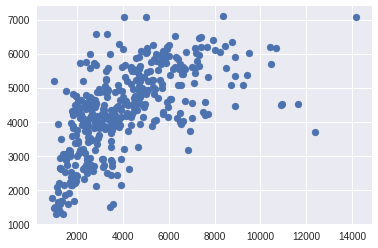

In [57]:
import pylab as pl
%matplotlib inline
pl.scatter(y_test,random_forest.predict(X_test))

...not even close, but not too far.


## Conclusions
I gave some useful tool and information that can be used to manage an Instagram account.
Is it able to predict the *correct* number of likes of a given photo? Nope, but it can give you a magnitude of your potential organic audience, and I think that's pretty interesting. 

In [44]:
data_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,%H_14,%H_15,%H_16,%H_17,%H_18,%H_19,%H_20,%H_21,%H_22,%H_23
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
